<h1><center>Subspace Identification: Fractionator example</center></h1>

![PFD](frac.jpg)

**Reflux (FIC-2001)**
Increasing reflux (and keeping everything else constant) will decrease the Top Product (FIC-2101) and increase the bottoms product (FIC-2102) by the same amount.

**Mid Product (FIC-2002)**
Increasing the side draw FIC-2002 will affect FIC-2101 and FIC-2102. If we increase the side draw by 1 unit then both top and bottoms product will have to decrease by 1 unit.

**Feed Temperature (TIC-2003)**
Increasing the feed temperature also affects the mass balance in the fractionator and the feed is split in the top and bottoms product.

**Mid Reflux (FIC-2004)**
Increasing the mid reflux (FIC-2004) will also affect both top and bottoms product flow:

In [1]:
import numpy as np
import pandas as pd
from scipy import signal, stats, fftpack
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from sysidbox.subspace import system_identification
from sysidbox.functionsetSIM import get_model_uncertainty, get_deadtime, get_fir_coef, get_step_response, simulate_fir
from harold import simulate_step_response, simulate_impulse_response, undiscretize, discretize
from detrend.detrending_filter import DetrendingFilter
# %matplotlib widget

In [2]:
# Load spteptest data from a TSV file
file = os.path.join(os.path.dirname(os.getcwd()),'data','FRAC2.csv')
columns = ['Time', 'AI-2020', 'AI-2021', 'AI-2022', 'FIC-2100', 'FIC-2101', 'FIC-2102', 'FI-2005', 'FIC-2001', 'FIC-2002', 'FIC-2004', 'QI-2106', 'TIC-2003']
step_test_data = pd.read_csv(file,skiprows=[1,2,3], usecols=columns, index_col='Time', parse_dates=True)

In [3]:
step_test_data.head()

AI-2020  AI-2021  AI-2022  FIC-2100  FIC-2101  FIC-2102  \
Time                                                                           
2015-10-01 08:14:00  2.00000  3.00000  4.00000   8.50000   2.10000   1.70000   
2015-10-01 08:15:00  2.00360  3.00954  3.99831   8.50735   2.09686   1.71730   
2015-10-01 08:16:00  2.00870  2.99518  3.97746   8.50977   2.09280   1.72500   
2015-10-01 08:17:00  2.00385  3.01356  3.97262   8.50838   2.08587   1.71878   
2015-10-01 08:18:00  1.99852  3.02963  3.98841   8.50365   2.08028   1.71360   

                     FI-2005  FIC-2001  FIC-2002  FIC-2004  QI-2106  TIC-2003  
Time                                                                           
2015-10-01 08:14:00  5.02153       2.5       1.5       8.0  2.00000     200.0  
2015-10-01 08:15:00  4.98768       2.5       1.5       8.0  1.99772     200.0  
2015-10-01 08:16:00  4.93990       2.5       1.5       8.0  1.99552     200.0  
2015-10-01 08:17:00  4.93333       2.5       1.5       8.0  1.99483     200.0  
2015-10-01 08:18:00  4.96880       2.5       1.5       8.0  1.99465     200.0

In [3]:
step_test_data.describe()

AI-2020      AI-2021      AI-2022     FIC-2100     FIC-2101  \
count  5820.000000  5820.000000  5820.000000  5820.000000  5820.000000   
mean   -154.245680     3.347584     3.974376     9.033256     2.924300   
std    1240.862066     0.234960     0.364111     0.535641     0.810603   
min   -9999.000000     2.820780     3.067540     7.999970     1.167090   
25%       1.809913     3.169485     3.777985     8.558795     2.273465   
50%       2.115230     3.301415     4.020915     8.996355     2.827195   
75%       2.434028     3.517735     4.226025     9.412683     3.594180   
max       3.297840     3.930950     4.856360    10.611500     4.838140   

          FIC-2102      FI-2005     FIC-2001     FIC-2002     FIC-2004  \
count  5820.000000  5820.000000  5820.000000  5820.000000  5820.000000   
mean      1.795645     5.994956     2.731959     1.556701     8.365979   
std       0.595210     0.619313     0.400175     0.236797     0.761627   
min       0.273632     0.000000     1.500000     1.000000     7.000000   
25%       1.389850     5.548435     2.500000     1.500000     8.000000   
50%       1.794675     6.004360     3.000000     1.500000     8.000000   
75%       2.183885     6.500992     3.000000     1.500000     9.000000   
max       3.446710    11.534700     3.500000     2.000000    10.000000   

           QI-2106     TIC-2003  
count  5820.000000  5820.000000  
mean      2.175489   200.278351  
std       0.485643     0.646094  
min       0.380137   199.000000  
25%       1.869215   200.000000  
50%       2.028820   200.000000  
75%       2.513087   200.500000  
max       3.986420   202.000000

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

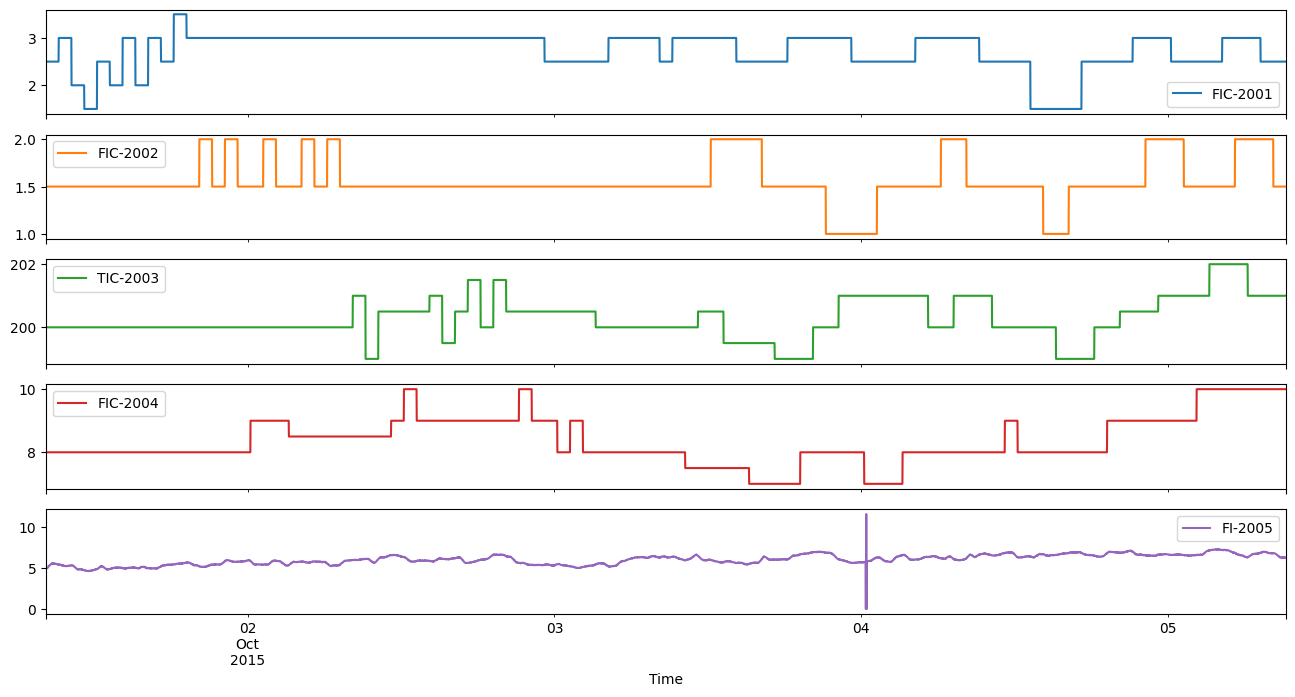

In [4]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100
step_test_data[['FIC-2001', 'FIC-2002','TIC-2003', 'FIC-2004','FI-2005']].iloc[:].plot(subplots=True)

In [5]:
inputs = ['FIC-2001','FIC-2002', 'TIC-2003', 'FIC-2004','FI-2005']
outputs = ['FIC-2101', 'FIC-2102']

In [6]:
#slice data for model identification case
slices = {
            "slice1":{"type":"bad", "isGlobal": False, "start":1040, "end":1135, "Description": "OPC bad for AI-2020","tags":['AI-2020']}, 
            "slice2":{"type":"interpolate", "isGlobal": False,"start":3845, "end":3855, "Description": "Suspicious value for  FI-2005", "tags":['FI-2005']}
        }

In [7]:
#specify model identification parameters, reffer the documentation for detais.
tss = 120                  # Process time to steady state
controller_sampling = 1    # Controller sampling time
filter_tss_mult_factor = 3 # 3 for self-regulating CV, 6 for ramp CV
resampling = 1             # For tss more than 90 use 2, and if grater than 240 use 3 
id_method='CVA'            # CVA, MOESP, N4SID
IC = 'AIC'                 # None, AIC, AICc, BIC
TH =  100                  # The length of time horizon used for regression
fix_ordr = 23              # Used if and only if IC = 'None'
ss_orders = [1, 45]        # SS orser min and max, Used if IC = AIC, AICc or BIC
SS_threshold = 0.1         # Singular value threshold
req_D = True
force_A_stable = False

In [8]:
# Create FIR filter to detrend signal 
tags = inputs + outputs
filter_type  = 'highpass' # Valid filters ['highpass', 'difference', 'doubledifference', 'zeromean', 'none']
d_filter = DetrendingFilter().get_filter(filter_type)
if filter_type == 'highpass':
    d_filter.apply_filter(step_test_data[tags], tss, filter_tss_mult_factor, slices)
else:
    d_filter.apply_filter(step_test_data[tags], slices)
    
idinput = d_filter.filterdata.data["output"]

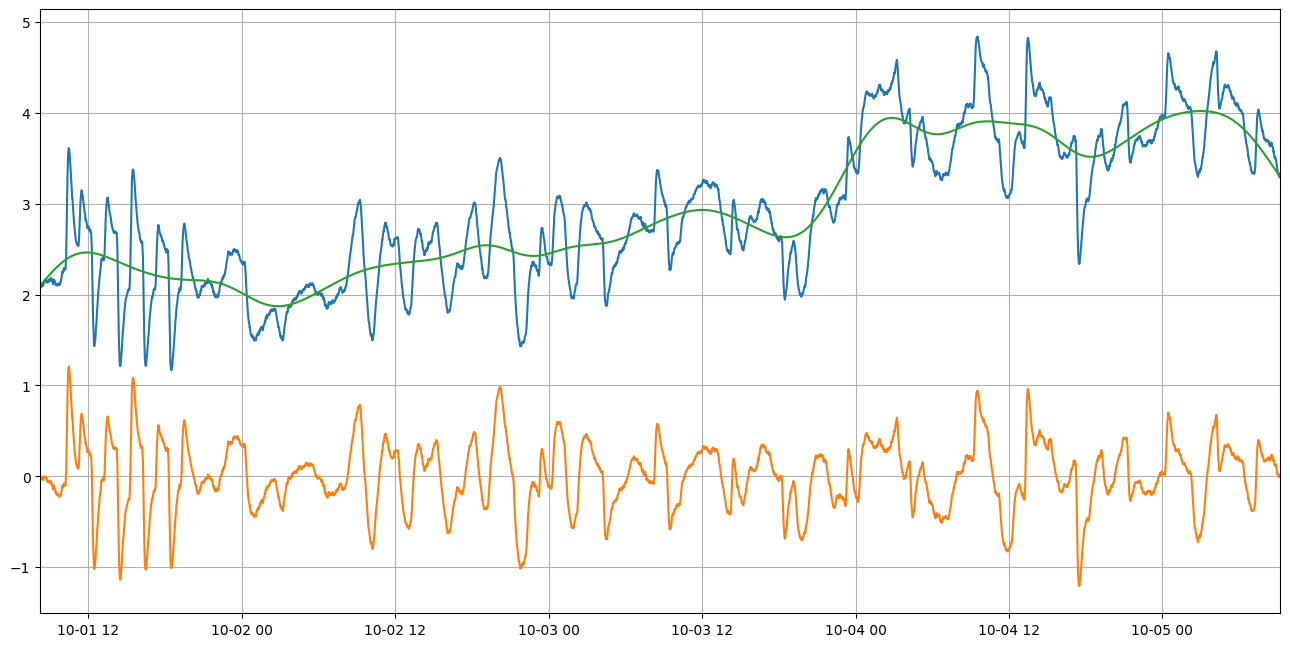

In [9]:
tag = 'FIC-2101'
trend = d_filter.filterdata.data["trend"]
plt.plot(step_test_data.index, step_test_data[tag], idinput.index, idinput[tag], trend.index, trend[tag])
plt.margins(x=0)
plt.grid()

In [10]:
# Resample datadet
idinput_resampled = idinput.resample(str(resampling)+'min').mean()
tsample = pd.Timedelta(idinput_resampled.index[1] - idinput_resampled.index[0]).total_seconds() # data sampling time
# Convert dataframe to numpy array in the shape requied for SIPPY
u = idinput_resampled[inputs].to_numpy().T
y = idinput_resampled[outputs].to_numpy().T
print('Output shape:', y.shape)
print('Input shape:',u.shape)

Output shape: (2, 5820)
Input shape: (5, 5820)


In [11]:
id_result = system_identification(
    y=y,
    u=u,
    id_method=id_method,
    tsample= tsample,
    SS_fixed_order=fix_ordr,
    SS_orders=ss_orders,
    SS_threshold=SS_threshold,
    IC=IC,
    SS_f=TH,
    SS_D_required=req_D,
    SS_A_stability=force_A_stable
    )

The suggested order is: n= 12


In [12]:
firmodel = get_fir_coef(model=id_result.G, inds=inputs, deps=outputs, sampling=60, tss=tss)
step_response = get_step_response(firmodel)
t = np.arange(0, tss)

## DMC3 reference model
![model](model_plot.jpg)

## DMC3 reference uncertinity plot
![uncertinity](model_uncertinity.jpg)

In [13]:
input_tag = 'FIC-2001'
output_tag = 'FIC-2101'

In [14]:
imp_ij = firmodel[output_tag][input_tag]
stp_ij = step_response[output_tag][input_tag]
u = idinput[input_tag]
y = idinput[output_tag]

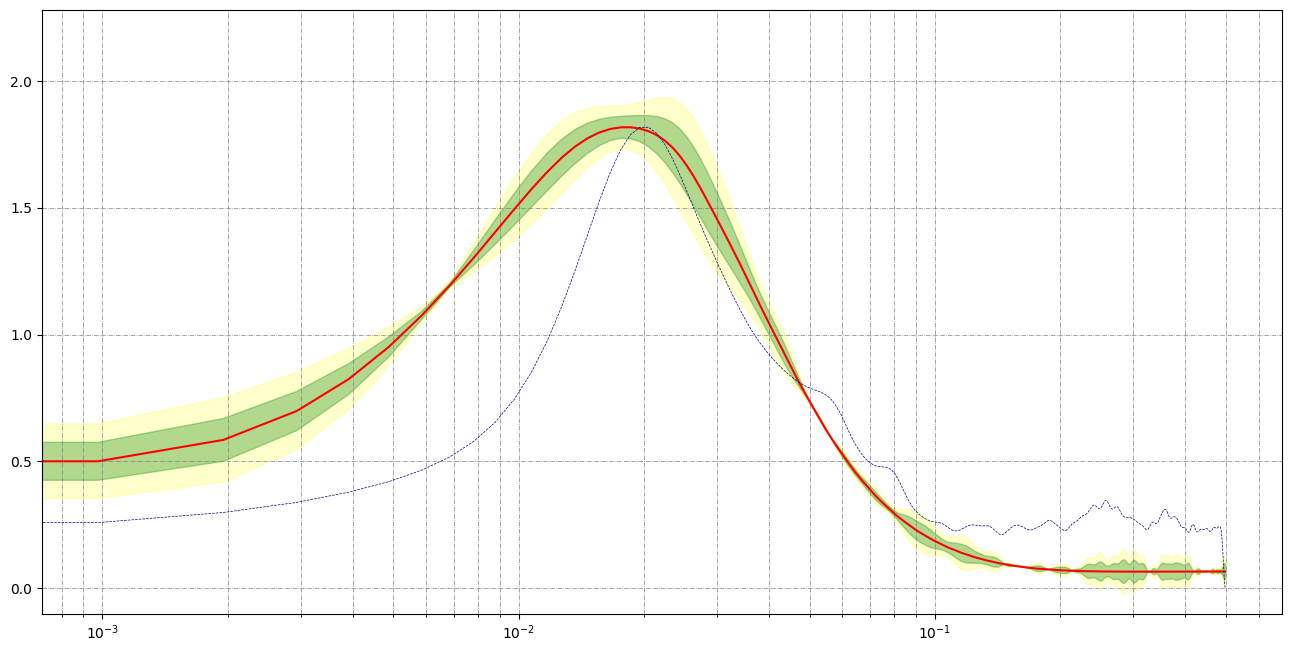

In [15]:
freqs, mag, ci95, ci68, snr = get_model_uncertainty(u, y, imp_ij)
snr_scaled = np.interp(snr, (snr.min(), snr.max()), (0, max(mag)))
plt.figure(2)
axes = plt.gca()
ylim = max(mag)*1.2
axes.set_ylim([-0.1,ylim+0.1])
axes.plot(freqs, mag, color='red')
axes.plot(freqs, snr_scaled, color='navy',linestyle="--", linewidth=0.5)
axes.fill_between(freqs, (mag-ci95), (mag+ci95), color='yellow', alpha=0.2)
axes.fill_between(freqs, (mag-ci68), (mag+ci68), color='green', alpha=0.3)
axes.semilogx()
axes.grid(True, which="both",color='gray', linestyle="-.", linewidth=0.5)

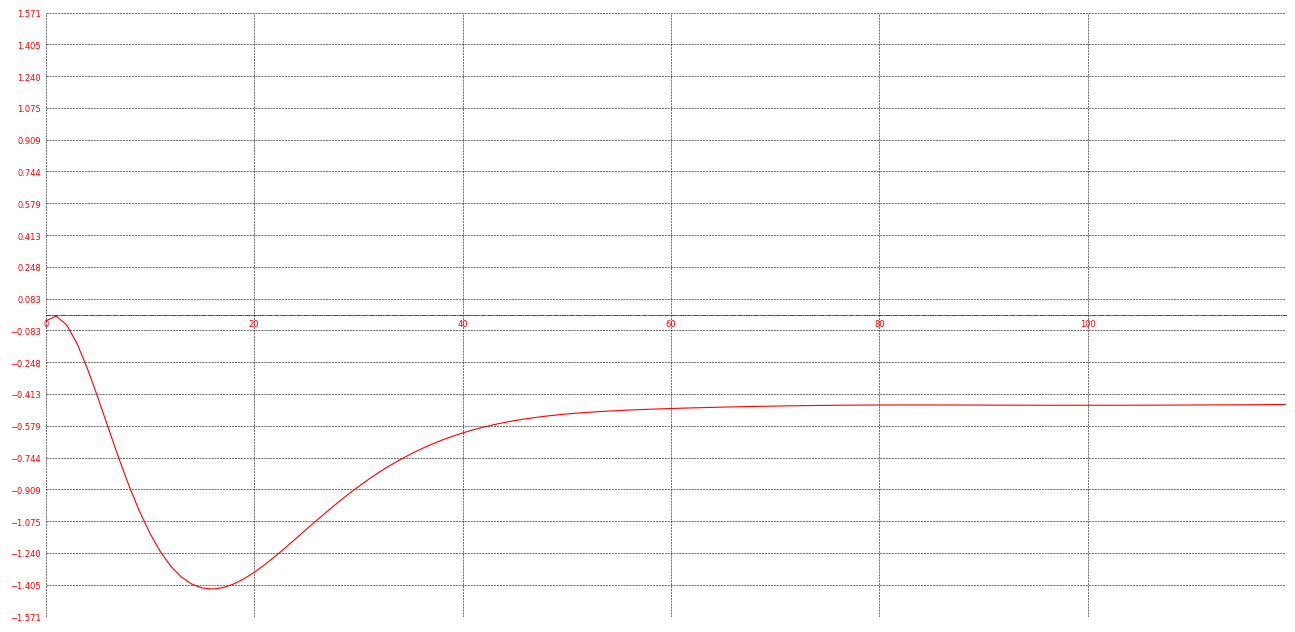

In [16]:
plt.figure(1)
axes = plt.gca()
ylim = max(abs(stp_ij))*1.1
axes.set_ylim([-ylim,ylim])
colr = "red"
axes.grid(color='k', linestyle='--', linewidth=0.4)
axes.spines.bottom.set_position('zero')
axes.spines.bottom.set_linestyle('-.')
axes.spines.bottom.set_linewidth(0.5)
axes.spines[['left', 'top', 'right']].set_visible(False)
axes.xaxis.set_ticks_position('bottom')
axes.yaxis.set_ticks_position('left')
plt.xticks(np.arange(0, tss+2, 20.0))
plt.yticks(np.linspace(-ylim, ylim, 20))
axes.tick_params(axis='x', colors=colr,size=0,labelsize=6)
axes.tick_params(axis='y', colors=colr,size=0,labelsize=6)
axes.margins(x=0, y=0)
plt.plot(t, stp_ij, color=colr, linewidth=0.8)

## Dead-time identification using white noise injection

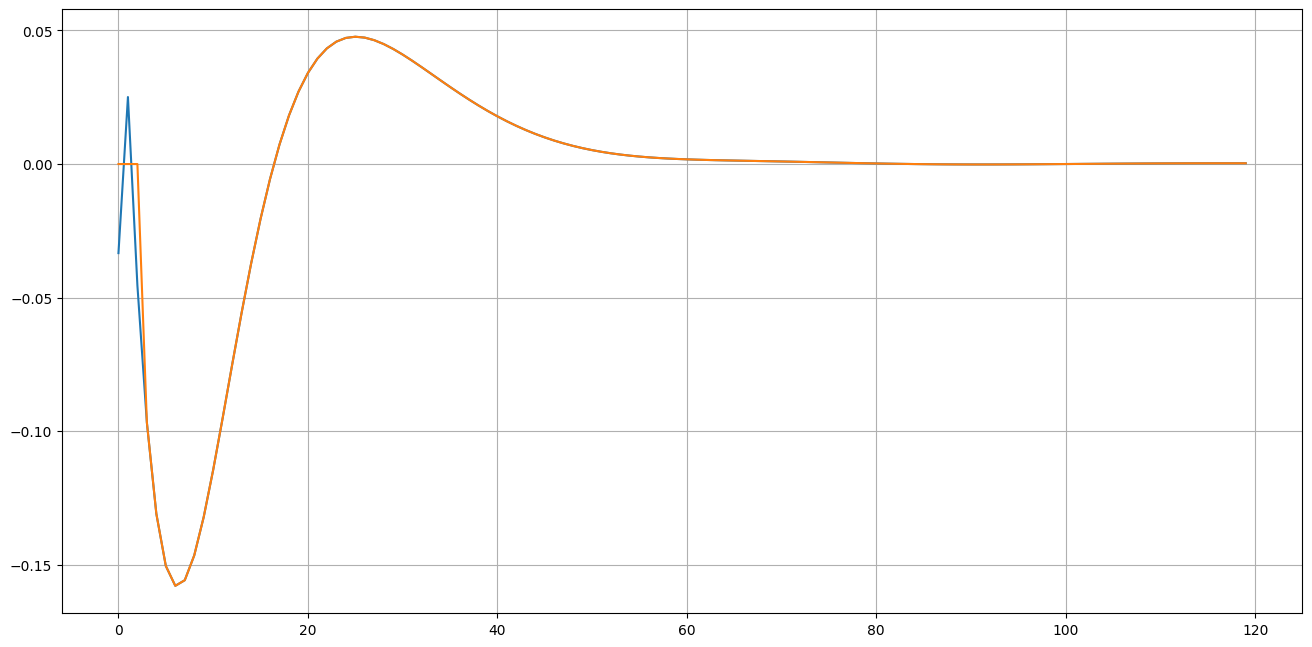

In [17]:
deadtime = get_deadtime(stp_ij)
imp_ij_shift = imp_ij.copy()
if deadtime > 1:
    imp_ij_shift[:deadtime] = 0
plt.plot(imp_ij)
plt.plot(imp_ij_shift)
plt.grid()

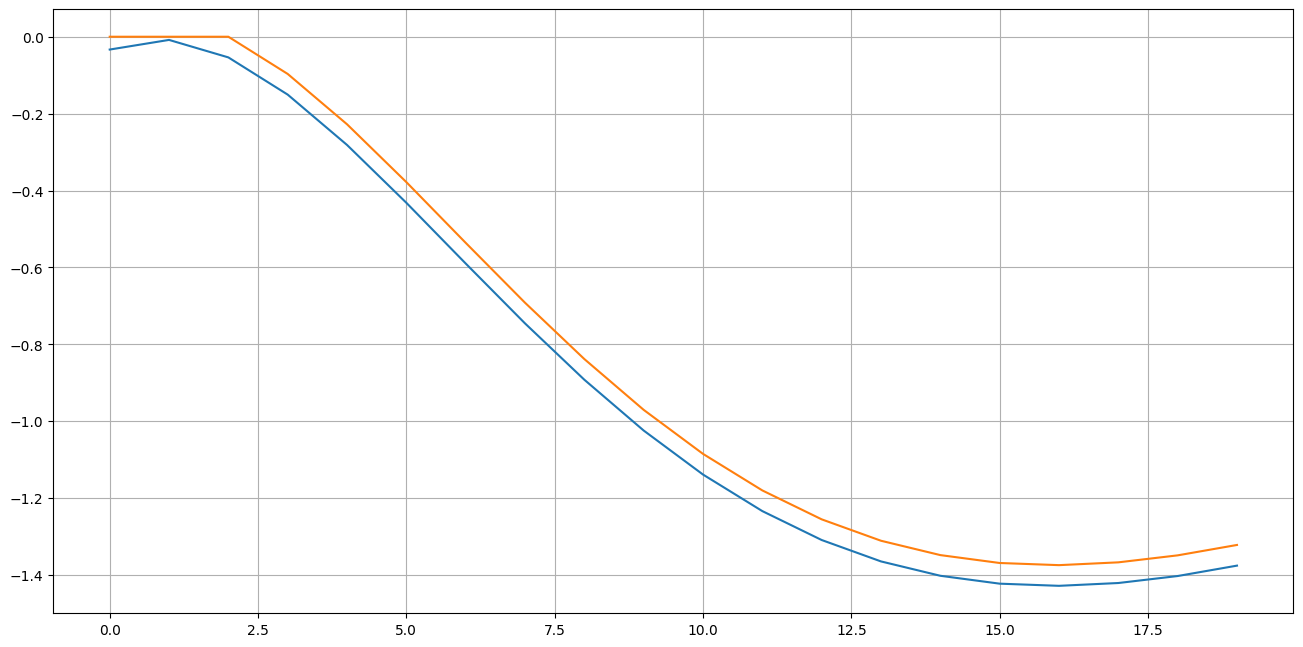

In [18]:
shift_step = np.cumsum(imp_ij_shift)
plt.plot(stp_ij[:20])
plt.plot(shift_step[:20])
plt.grid()

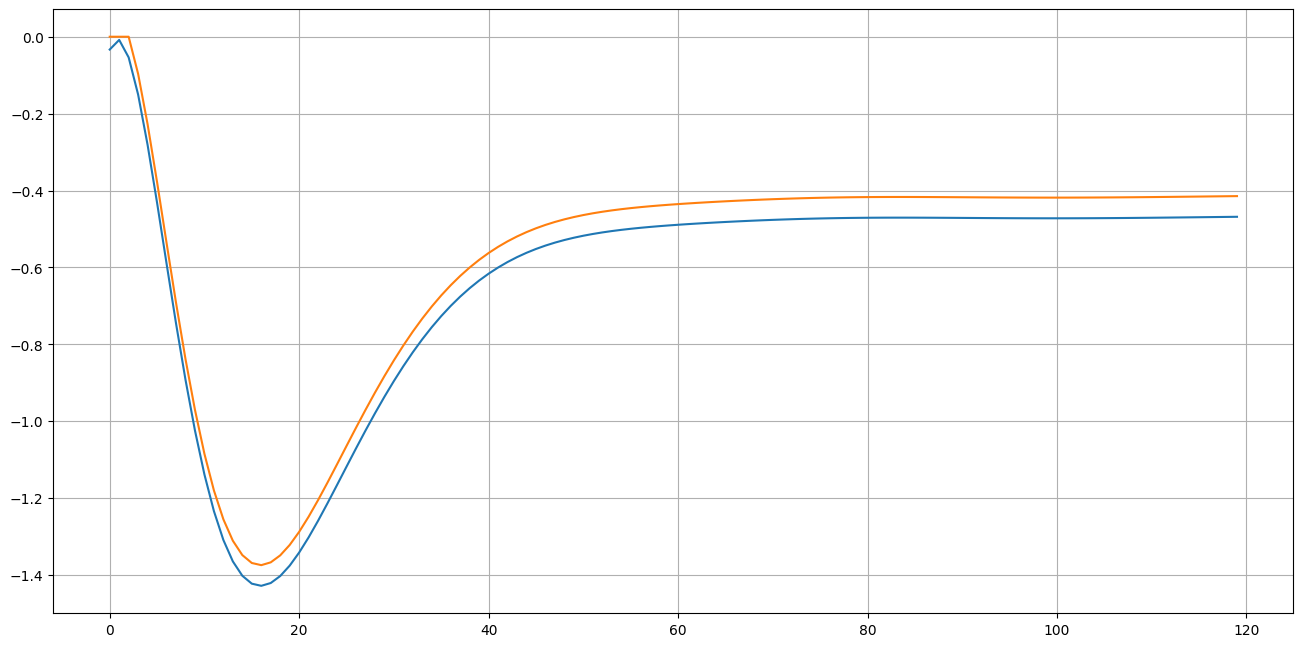

In [19]:
shift_step = np.cumsum(imp_ij_shift)
plt.plot(stp_ij)
plt.plot(shift_step)
plt.grid()

In [20]:
pred = simulate_fir(firmodel, step_test_data)

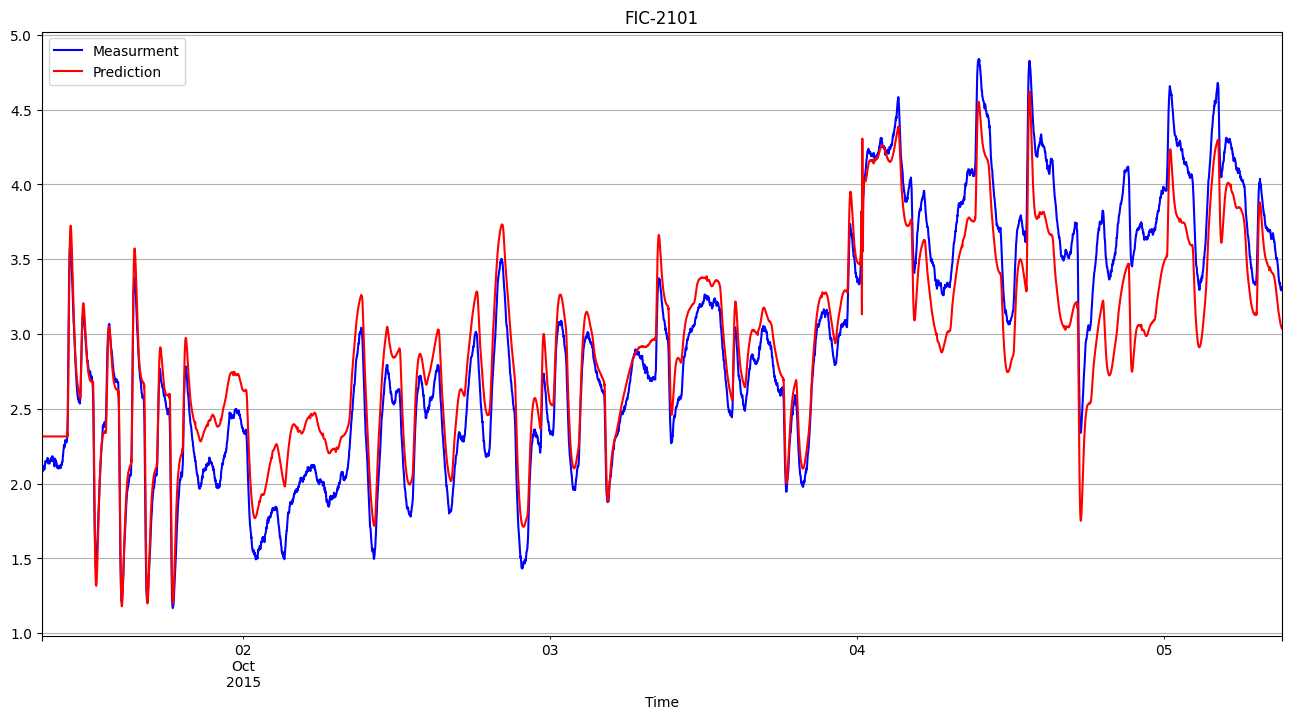

In [21]:
step_test_data[output_tag].plot(color='b', label = 'Measurment')
pred[output_tag].plot(color='r', label = 'Prediction')
plt.title(output_tag)
plt.legend()
plt.grid()